<a href="https://colab.research.google.com/github/LivioXie/ICSI435_Group/blob/main/GAN_proto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1, Generator Loss: 0.6782510876655579, Discriminator Loss: 0.758951723575592
Epoch 2, Generator Loss: 0.6953996419906616, Discriminator Loss: 0.7147318720817566
Epoch 3, Generator Loss: 0.7288620471954346, Discriminator Loss: 0.6751790642738342
Epoch 4, Generator Loss: 0.7713083028793335, Discriminator Loss: 0.6343433856964111
Epoch 5, Generator Loss: 0.8304993510246277, Discriminator Loss: 0.58482825756073
Epoch 6, Generator Loss: 0.8956140279769897, Discriminator Loss: 0.5362966060638428
Epoch 7, Generator Loss: 0.9717088937759399, Discriminator Loss: 0.4859165847301483
Epoch 8, Generator Loss: 1.0704339742660522, Discriminator Loss: 0.4292868375778198
Epoch 9, Generator Loss: 1.2065505981445312, Discriminator Loss: 0.36358824372291565
Epoch 10, Generator Loss: 1.3834025859832764, Discriminator Loss: 0.2949753701686859
Epoch 11, Generator Loss: 1.5786333084106445, Discriminator Loss: 0.23611003160476685
Epoch 12, Generator Loss: 1.7964228391647339, Discriminator Loss: 0.1855603

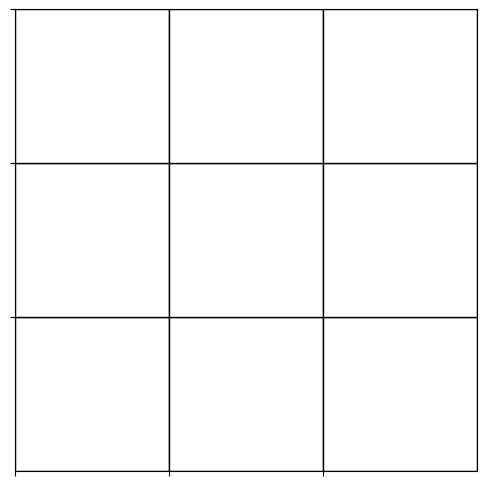

Epoch 101, Generator Loss: 8.133129119873047, Discriminator Loss: 0.00030260757193900645
Epoch 102, Generator Loss: 8.17160415649414, Discriminator Loss: 0.000291215896140784
Epoch 103, Generator Loss: 8.192831039428711, Discriminator Loss: 0.0002851090976037085
Epoch 104, Generator Loss: 8.208566665649414, Discriminator Loss: 0.00028037730953656137
Epoch 105, Generator Loss: 8.242059707641602, Discriminator Loss: 0.00027118847356177866
Epoch 106, Generator Loss: 8.260122299194336, Discriminator Loss: 0.00026605118182487786
Epoch 107, Generator Loss: 8.293367385864258, Discriminator Loss: 0.0002576175902504474
Epoch 108, Generator Loss: 8.32768440246582, Discriminator Loss: 0.0002488491008989513
Epoch 109, Generator Loss: 8.368842124938965, Discriminator Loss: 0.00023904911358840764
Epoch 110, Generator Loss: 8.386055946350098, Discriminator Loss: 0.00023493559274356812
Epoch 111, Generator Loss: 8.403392791748047, Discriminator Loss: 0.00023080936807673424
Epoch 112, Generator Loss: 8

KeyboardInterrupt: 

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, LeakyReLU, BatchNormalization
import matplotlib.pyplot as plt

# Constants
PUZZLE_SIZE = 3  # 3x3 puzzle
SEED_SIZE = 100
EPOCHS = 1000
BATCH_SIZE = 32

# Generate random 3x3 sliding puzzle configurations
def generate_puzzle_batch(batch_size):
    puzzles = []
    for _ in range(batch_size):
        puzzle = np.arange(PUZZLE_SIZE * PUZZLE_SIZE)
        np.random.shuffle(puzzle)
        puzzle = puzzle.reshape((PUZZLE_SIZE, PUZZLE_SIZE))
        puzzles.append(puzzle)
    return np.array(puzzles)

# Generator
def build_generator(seed_size):
    model = Sequential()
    model.add(Dense(128, input_dim=seed_size))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Dense(PUZZLE_SIZE * PUZZLE_SIZE, activation='softmax'))
    model.add(Reshape((PUZZLE_SIZE, PUZZLE_SIZE)))
    return model

# Discriminator
def build_discriminator():
    model = Sequential()
    model.add(Flatten(input_shape=(PUZZLE_SIZE, PUZZLE_SIZE)))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(1, activation='sigmoid'))
    return model

# Loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Build models
generator = build_generator(SEED_SIZE)
discriminator = build_discriminator()

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4, 0.5)

# Training step
@tf.function
def train_step(puzzles):
    noise = tf.random.normal([BATCH_SIZE, SEED_SIZE])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_puzzles = generator(noise, training=True)

        real_output = discriminator(puzzles, training=True)
        fake_output = discriminator(generated_puzzles, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Training loop
def train(dataset, epochs):
    for epoch in range(epochs):
        for puzzle_batch in dataset:
            gen_loss, disc_loss = train_step(puzzle_batch)

        # Print progress
        print(f"Epoch {epoch + 1}, Generator Loss: {gen_loss}, Discriminator Loss: {disc_loss}")

        # Generate and save a sample puzzle
        if (epoch + 1) % 100 == 0:
            sample_puzzle(generator)

# Function to sample a generated puzzle and plot
# Function to sample a generated puzzle and plot with labels
# Function to sample a generated puzzle and plot with labels
def sample_puzzle(generator_model):
    noise = tf.random.normal([1, SEED_SIZE])
    generated_puzzle = generator_model(noise, training=False).numpy().reshape((PUZZLE_SIZE, PUZZLE_SIZE))

    print("Generated Puzzle:")
    print(generated_puzzle)

    # Plot with labels
    fig, ax = plt.subplots(figsize=(6, 6))
    for i in range(PUZZLE_SIZE):
        for j in range(PUZZLE_SIZE):
            num = int(generated_puzzle[i, j])  # Convert to int to display as a number
            color = 'lightblue' if num != 0 else 'white'  # Set color for blank space (0)
            ax.add_patch(plt.Rectangle((j, PUZZLE_SIZE-i-1), 1, 1, facecolor=color, edgecolor='black'))

            if num != 0:  # Only add number to non-zero cells
                ax.text(j + 0.5, PUZZLE_SIZE-i-0.5, str(num), color='black', ha='center', va='center', fontsize=20)

    ax.set_xlim(0, PUZZLE_SIZE)
    ax.set_ylim(0, PUZZLE_SIZE)
    ax.set_xticks(np.arange(0, PUZZLE_SIZE, 1))
    ax.set_yticks(np.arange(0, PUZZLE_SIZE, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.gca().invert_yaxis()  # To match typical 2D array coordinates where the origin is top-left
    plt.show()



# Generate dataset and train
puzzle_data = generate_puzzle_batch(1000)
puzzle_dataset = tf.data.Dataset.from_tensor_slices(puzzle_data).batch(BATCH_SIZE)

train(puzzle_dataset, EPOCHS)
